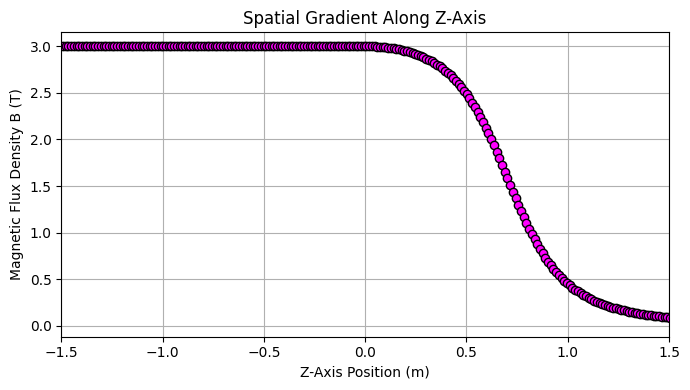

Maximum gradient occurs at z = 0.702 m, dB/dz = -5.384 T/m
Maximum gradient occurs at z = -2.000 m, dB/dz = 0.000 T/m
Magnetic field at z = -2.000 m is B = 3.000 T
Magnetic field at z = 0.702 m is B = 1.583 T


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
mu0 = 4 * np.pi * 1e-7
R = 0.3  # radius (m)
L = 1.4  # length (m)
B0 = 3.0  # central field (T)

# Function for on-axis B-field of a finite solenoid
def solenoid_field_on_axis(z, R, L, B0):
    z1 = z - L/2
    z2 = z + L/2
    B = 0.5 * ((z2 / np.sqrt(R**2 + z2**2)) - (z1 / np.sqrt(R**2 + z1**2)))
    # normalize so that center = B0
    return B / np.max(B) * B0

# Generate z-axis profile
z = np.linspace(-2, 2, 300)  # meters
Bz = solenoid_field_on_axis(z, R, L, B0)

# Find index of maximum Bz
idx_max = np.argmax(Bz)

# Replace Bz from min z to peak with constant B0
Bz[:idx_max] = B0

# ---- Figure 9: On-axis B vs Z ----
plt.figure(figsize=(7, 4))
plt.plot(z, Bz, 'o', markerfacecolor='magenta', markeredgecolor='k')
plt.title("Spatial Gradient Along Z-Axis")
plt.xlabel("Z-Axis Position (m)")
plt.ylabel("Magnetic Flux Density B (T)")
plt.xlim(-1.5, 1.5) 
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute numerical gradient
dBdz = np.gradient(Bz, z)  # dB/dz


# Maximum negative gradient
max_neg_idx = np.argmax(dBdz)
z_max_neg = z[max_neg_idx]
grad_max_neg = dBdz[max_neg_idx]
Bz_neg = solenoid_field_on_axis(z_max_neg,R, L, B0)


# Maximum positive gradient
max_pos_idx = np.argmin(dBdz)
z_max_pos = z[max_pos_idx]
grad_max_pos = dBdz[max_pos_idx]
Bz_pos = solenoid_field_on_axis(z_max_pos,R, L, B0)


B_at_max_neg = Bz[max_neg_idx]
B_at_max_pos = Bz[max_pos_idx]

print(f"Maximum gradient occurs at z = {z_max_pos:.3f} m, dB/dz = {grad_max_pos:.3f} T/m")
print(f"Maximum gradient occurs at z = {z_max_neg:.3f} m, dB/dz = {grad_max_neg:.3f} T/m")

print(f"Magnetic field at z = {z_max_neg:.3f} m is B = {B_at_max_neg:.3f} T")
print(f"Magnetic field at z = {z_max_pos:.3f} m is B = {B_at_max_pos:.3f} T")


Good this aligns okay with [this](https://mriquestions.com/most-dangerous-place.html), that says the gradient for a 3T is about 5 to 7 $T/m$ at the bore entrance
with a product of BgradB of 10 to 17 $T^2/m$

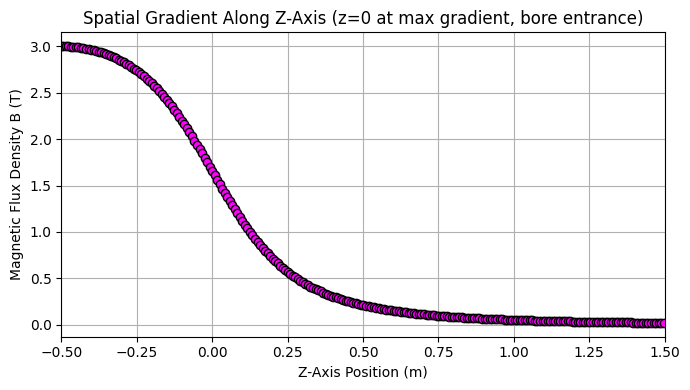

In [2]:
# Shift z so that z=0 at max negative gradient
z_shifted = z - z_max_pos

# ---- Plot shifted B vs z ----
plt.figure(figsize=(7, 4))
plt.plot(z_shifted, Bz, 'o', markerfacecolor='magenta', markeredgecolor='k')
plt.title("Spatial Gradient Along Z-Axis (z=0 at max gradient, bore entrance)")
plt.xlabel("Z-Axis Position (m)")
plt.ylabel("Magnetic Flux Density B (T)")
plt.xlim(-0.5, 1.5) 
plt.grid(True)
plt.tight_layout()
plt.savefig("Bz_vs_z.png", dpi=300, bbox_inches='tight')
plt.show()


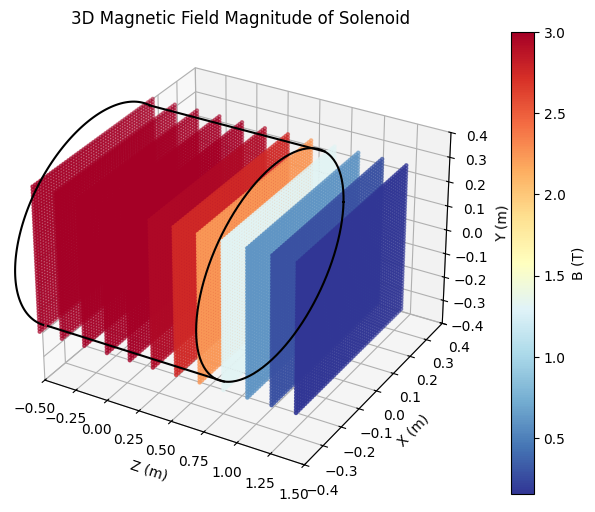

In [3]:
R = 0.3  # radius (m)
# Grid for x, y, z
coords = np.linspace(-R, R, 50)  #X&Y
z = np.linspace(0, 2, 12)  # coarser grid for plotting
z_shifted = z - z_max_pos

X, Y, Z = np.meshgrid(coords, coords, z_shifted)

# Assume field magnitude depends only on position along z
B = solenoid_field_on_axis(Z, R, L, B0)

# Find index of max along z-axis
idx_max = np.argmax(B, axis=2)  # shape (50,50)

# Create a new array with same shape as B
B_corrected = np.zeros_like(B)

for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        peak = idx_max[i,j]
        B_corrected[i,j,:peak+1] = B0            # constant until peak
        B_corrected[i,j,peak+1:] = B[i,j,peak+1:]  # after peak, keep original


# Create figure
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')


# Plot a 3D scatter colored by B
p = ax.scatter(Z, X, Y, c=B_corrected.flatten(), cmap='RdYlBu_r', marker='.', s=20)

R = 0.4
# Full cylinder edges
theta_full = np.linspace(0, 2*np.pi, 200)
Y_edge_full = R * np.cos(theta_full)
Z_edge_full = R * np.sin(theta_full)

# Half circle (front opening, say upper half)
theta_half = np.linspace(1/4*np.pi, 5/4*np.pi, 100)  # adjust range for which half you want
Y_edge_half = R * np.cos(theta_half)
Z_edge_half = R * np.sin(theta_half)

# Back circle (full)
ax.plot([ L/2]*len(theta_full), Y_edge_full, Z_edge_full,
        color='black', linewidth=1.5, zorder=100)

# Front circle (half only)
ax.plot([-L/2]*len(theta_half), Y_edge_half, Z_edge_half,
        color='black', linewidth=1.5, zorder=101)
for a in np.linspace(4, 1/4*np.pi, 2):  # longitudinal lines
    ax.plot([-L/2, L/2], [R*np.cos(a)]*2, [R*np.sin(a)]*2,
            color='black', linewidth=1.5, zorder=100)


ax.set_xlabel("Z (m)")
plt.xlim(-0.5, 1.5)
ax.set_ylim(-0.4, 0.4)   # extend beyond ±R for better visibility
ax.set_zlim(-0.4, 0.4)
ax.set_ylabel("X (m)")
ax.set_zlabel("Y (m)")
ax.set_title("3D Magnetic Field Magnitude of Solenoid")
fig.colorbar(p, ax=ax, label='B (T)')
fig.savefig("3D_field_plot.png", dpi=150, bbox_inches='tight')
plt.show()

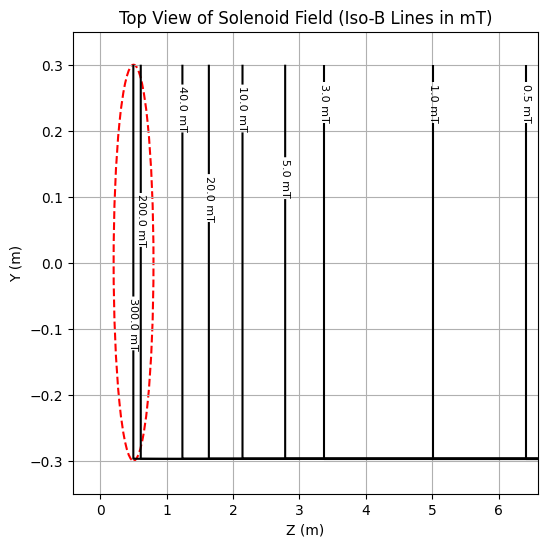

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
R = 0.3  # radius of solenoid (m)
L = 1.0  # length (m)
B0 = 3.0  # central field (T)

# Define top-view levels in mT
levels = [0.5, 1, 3, 5, 10, 20, 40, 200, 300]

# Create a grid in the transverse plane (Y,Z)
N = 200
Y, Z = np.meshgrid(np.linspace(-R, R, N), np.linspace(0, 7, N))

B = solenoid_field_on_axis(Z, R, L, B0)

# Find index of maximum B along each row (Z-axis)
idx_max = np.argmax(B, axis=1)

# Create a 2D array and apply "constant until peak"
B_2d = np.zeros_like(B)
for i in range(B.shape[0]):
    peak = idx_max[i]
    B_2d[i,:peak+1] = B0
    B_2d[i,peak+1:] = B[i,peak+1:]

# Convert to mT
B_top_mT = B_2d * 1000

# Current location of 300 mT line
z_300 = 0.91  # from the contour check

# Desired location
z_target = 0.5

# Compute shift
shift = z_target - z_300

# Shift Z grid
Z_shifted = Z + shift

# contour plot
plt.figure(figsize=(6,6))
cont = plt.contour(Z_shifted, Y, B_top_mT, levels=levels, colors='k')
plt.clabel(cont, fmt='%1.1f mT', fontsize=8)

# Overlay bore outline (adjust for shift if needed)
circle = plt.Circle((0.503, 0), R, color='r', fill=False, linestyle='--', linewidth=1.5)
plt.gca().add_patch(circle)

plt.ylim(-0.35, 0.35)   # Y-axis
#plt.axis('equal')
plt.xlabel("Z (m)")
plt.ylabel("Y (m)")
plt.title("Top View of Solenoid Field (Iso-B Lines in mT)")
plt.grid(True)
plt.show()

Contour 0 for 300 mT: Z from 0.91 to 7.00, Y from -0.30 to 0.30


/var/folders/rq/4gv3g_sn73l94q6vfzvc2g6w0000gn/T/ipykernel_2411/1273009063.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = cont.collections[level_index].get_paths()  # list of Path objects


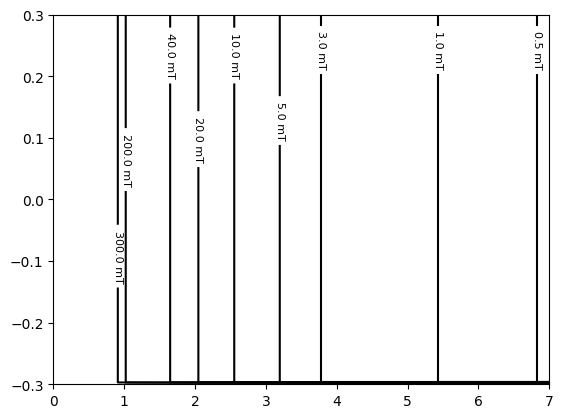

In [5]:
# Create contour plot
cont = plt.contour(Z, Y, B_top_mT, levels=levels, colors='k')

# Label contours
plt.clabel(cont, fmt='%1.1f mT', fontsize=8)

# Find the 300 mT contour paths
level_index = levels.index(300)  # index of 300 mT in levels
paths = cont.collections[level_index].get_paths()  # list of Path objects

# Each path contains coordinates of the contour line
for i, path in enumerate(paths):
    v = path.vertices
    z_coords = v[:,0]
    y_coords = v[:,1]
    print(f"Contour {i} for 300 mT: Z from {z_coords.min():.2f} to {z_coords.max():.2f}, "
          f"Y from {y_coords.min():.2f} to {y_coords.max():.2f}")


## What suceptibility should we used to scale this down to lab size Bfields ?

Bfields in the lab are of about 30 to 300 Gauss. 

In [6]:
B_gradB = np.abs(grad_max_pos) * B0
print(f"Max |B·gradB| ≈ {np.max(np.abs(B_gradB)):.3f} T²/m")


Max |B·gradB| ≈ 17.072 T²/m


In [7]:
for B0_gauss in [30, 100, 300]:  # Gauss
    B0_T = B0_gauss * 1e-4  # convert to Tesla
    scale = B0_T / 3.0       # relative to 3 T model

    Bz_scaled = Bz * scale
    dBdz_scaled = dBdz * scale
    BgradB_scaled = B_gradB * (scale ** 2)

    print(f"\n--- For B0 = {B0_gauss} G ({B0_T:.3e} T) ---")
    print(f"Max |dB/dz| ≈ {np.max(np.abs(dBdz_scaled)):.3e} T/m")
    print(f"Max |B·gradB| ≈ {np.max(np.abs(BgradB_scaled)):.3e} T²/m")



--- For B0 = 30 G (3.000e-03 T) ---
Max |dB/dz| ≈ 5.691e-03 T/m
Max |B·gradB| ≈ 1.707e-05 T²/m

--- For B0 = 100 G (1.000e-02 T) ---
Max |dB/dz| ≈ 1.897e-02 T/m
Max |B·gradB| ≈ 1.897e-04 T²/m

--- For B0 = 300 G (3.000e-02 T) ---
Max |dB/dz| ≈ 5.691e-02 T/m
Max |B·gradB| ≈ 1.707e-03 T²/m


Mass sus 
$$
     \frac{\chi}{\rho}  = \mu_0 g \frac{tan(\alpha)}{B \nabla B}
$$

with 

- $\mu_0 = 1.25\times 10^{-6} N/A^2$
- $g = 9.8067$ m/s^2$


alpha is the angle for 1cm, lets say.


$
\alpha_1 = tan(10/1000)
$


In [8]:
#Constants

mu0 = 1.25663706127E-6 #N/A2
g = 9.8067 #m/s2
rho_lab = 7000 #any common metal kg/m3 //aluminum/steel/brass/nickel alloys

alpha1 = np.tan(10/1000)   # tan(theta) ~ 1cm/1m

In [10]:
import pandas as pd

# --- Function to compute rho*chi ---
def rho_chi(BgradB, alphas):
    return (mu0 * g * alphas) / BgradB

# --- Lab fields to scale ---
B0_gauss_list = [30, 300, 30000]  # Gauss

rows = []
for B0_g in B0_gauss_list:
    B0_T = B0_g * 1e-4  # convert to Tesla
    scale = B0_T / 3.0       # relative to 3 T model

    Bz_scaled = Bz * scale
    dBdz_scaled = dBdz * scale
    BgradB_scaled = B_gradB * (scale ** 2)
    rho_chi_vals = rho_chi(BgradB_scaled, alpha1)
    chi_lab_vals = rho_chi_vals * rho_lab


    rows.append({
        "B0_G": B0_g,
        "B0_T": B0_T,
        "BgradB_max_T2_per_m": BgradB_scaled,
        "rho_chi": rho_chi_vals,
        "chi_lab": chi_lab_vals,
    })

# --- Create table ---
df = pd.DataFrame(rows)
df["rho_chi"] = df["rho_chi"].map("{:.3e}".format)
df["chi_lab"] = df["chi_lab"].map("{:.3e}".format)

df = df[["B0_G","B0_T","BgradB_max_T2_per_m","rho_chi","chi_lab"]]

print("=== Required chi_lab and rho*chi for scaled B0s (ρ ≈ 7000 kg/m³ metal) ===")
print(df.to_string(index=False))

=== Required chi_lab and rho*chi for scaled B0s (ρ ≈ 7000 kg/m³ metal) ===
 B0_G  B0_T  BgradB_max_T2_per_m   rho_chi   chi_lab
   30 0.003             0.000017 7.219e-03 5.053e+01
  300 0.030             0.001707 7.219e-05 5.053e-01
30000 3.000            17.071583 7.219e-09 5.053e-05


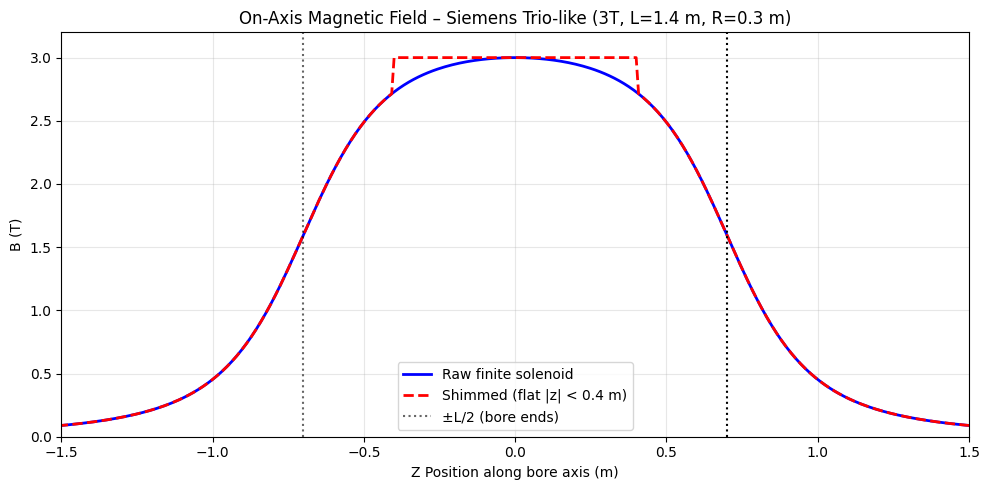

Steepest positive gradient:  5.387 T/m at z = -0.704 m
Steepest negative gradient: -5.387 T/m at z = +0.704 m
B at steepest neg gradient point: 1.574 T
B at steepest pos gradient point: 1.574 T


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
mu0 = 4 * np.pi * 1e-7
R = 0.3       # radius (m)   ← correct for ~60 cm bore
L = 1.4       # length (m)   ← approx Siemens Trio bore length
B0 = 3.0      # central field (T)

# Correct on-axis field (normalized then scaled to B0 at center)
def solenoid_field_on_axis(z, R, L, B0):
    za = z + L/2                     # distance to entrance end
    zb = z - L/2                     # distance to exit end
    term_a = za / np.sqrt(R**2 + za**2)
    term_b = zb / np.sqrt(R**2 + zb**2)
    B = 0.5 * (term_a - term_b)      # this gives positive B along +z
    B_center = 0.5 * ( (L/2)/np.sqrt(R**2 + (L/2)**2) * 2 )  # analytic at z=0
    return B / B_center * B0

# Generate z profile
z = np.linspace(-2, 2, 501)          # finer grid for smoothness
Bz = solenoid_field_on_axis(z, R, L, B0)

# Optional: force ultra-flat central region like shimmed MRI (imaging FOV ~40-50 cm)
z_center = 0.40                      # flat over ±20 cm (adjust to taste)
mask_flat = np.abs(z) < z_center
Bz_shimmed = Bz.copy()
Bz_shimmed[mask_flat] = B0           # perfect uniformity in central volume

# Plot both for comparison
plt.figure(figsize=(10, 5))

plt.plot(z, Bz, 'b-', lw=2, label='Raw finite solenoid')
plt.plot(z, Bz_shimmed, 'r--', lw=2, label=f'Shimmed (flat |z| < {z_center} m)')

plt.axvline(-L/2, color='k', ls=':', alpha=0.6, label='±L/2 (bore ends)')
plt.axvline( L/2, color='k', ls=':')

plt.title("On-Axis Magnetic Field – Siemens Trio-like (3T, L=1.4 m, R=0.3 m)")
plt.xlabel("Z Position along bore axis (m)")
plt.ylabel("B (T)")
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3.2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Gradient analysis on raw (non-shimmed) field
dBdz = np.gradient(Bz, z)
max_neg_idx = np.argmin(dBdz)   # most negative slope
max_pos_idx = np.argmax(dBdz)   # most positive slope

print(f"Steepest positive gradient:  {dBdz[max_pos_idx]:.3f} T/m at z = {z[max_pos_idx]:+.3f} m")
print(f"Steepest negative gradient: {dBdz[max_neg_idx]:.3f} T/m at z = {z[max_neg_idx]:+.3f} m")
print(f"B at steepest neg gradient point: {Bz[max_neg_idx]:.3f} T")
print(f"B at steepest pos gradient point: {Bz[max_pos_idx]:.3f} T")